In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
sys.path.append("../..")

import json
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from ast import literal_eval
from typing import List
from functools import reduce

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".93"})

from src.paper_data_processing import DataProcessing
from src.paper_analysis_hydropower import NationalAnalysisHydropower

In [3]:
paths_megadrought = json.load(open("../paths_megadroughts.json"))

path_data_megadrought = Path(paths_megadrought["path_data"])
path_data_hydro_megadrought = path_data_megadrought / "hydropower"
path_data_polygons_megadrought = path_data_megadrought / "polygons"
path_swiss_maps_megadrought = path_data_megadrought / "maps" / "swissboundaries3d_2023-01_2056_5728/"
path_figs_megadrought = Path(paths_megadrought["path_figs"])

paths_historical = json.load(open("../paths.json"))

path_data_historical = Path(paths_historical["path_data"])
path_data_hydro_historical = path_data_historical / "hydropower"
path_data_polygons_historical = path_data_historical / "polygons"
path_swiss_maps_historical = path_data_historical / "maps" / "swissboundaries3d_2023-01_2056_5728/"
path_figs_historical = Path(paths_historical["path_figs"])

In [4]:
data_processing = DataProcessing("../paths_megadroughts.json")

Loading data


# Transform data
Example code

```python
ds = xr.open_dataset(data_processing.path_data_prevah / "netcdf" / "EMC8_2015-2019_RGS_2024.nc")
for nc_file in (data_processing.path_data_prevah / "netcdf_old").glob("*"):
    xr.open_dataset(nc_file).rename({"lat2": "y", "lon2": "x", "RGS": "rgs"}).sortby("time").to_netcdf(data_processing.path_data_prevah / "netcdf" / nc_file.name)
```

# Load data

In [5]:
gdf_switzerland = gpd.read_file(path_swiss_maps_megadrought / "swissBOUNDARIES3D_1_4_TLM_LANDESGEBIET.shp").to_crs("EPSG:2056")

## Load BAFU polygons
gdf_polygons = gpd.read_file(path_data_polygons_megadrought / "EZG_Gewaesser.gpkg")

## Load collocated hydropower locations and BAFU polygons
df_hydropower_polygons = pd.read_json(path_data_hydro_megadrought / "hydropower_polygons" / "df_hydropower_polygons.json", orient="records")
gdf_hydropower_polygons = gpd.GeoDataFrame(df_hydropower_polygons, geometry=gpd.points_from_xy(df_hydropower_polygons["_x"], df_hydropower_polygons["_y"]), crs="EPSG:2056")

## Load hydropower characteristics
df_wasta = pd.read_excel(path_data_hydro_megadrought / "stats_hydropower_ch" / "wasta_2023_updated.xlsx")

## Load historical Swiss electricity generation data
df_historical_data = pd.read_csv(path_data_megadrought / "energy" / "ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv")

## Load past data

In [14]:
## Load hydropower production (with simplified efficiency and with/without beta coefficient)
ds_hydropower_generation_historical = xr.open_dataset(path_data_hydro_historical / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency.nc").rename({"gen": "hp_no_beta"}).load()
df_hydropower_production_historical_params = pd.read_csv(path_data_hydro_historical / "hydropower_generation" / "ds_prevah_500_hydropower_production_parameters.csv")
df_hydropower_production_historical_params.loc[df_hydropower_production_historical_params["Expected yearly generation"] == 0, "Expected yearly generation"] = \
    df_hydropower_production_historical_params[df_hydropower_production_historical_params["Expected yearly generation"] == 0].apply(lambda row: round(row["Capacity"] * 365 * 24 * 1e-6, 2), axis=1)


ds_monthly_bias_correction_factors_historical = xr.open_dataset(path_data_hydro_historical / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_monthly_bias_correction_factors.nc").bias_correction_factor.load()

In [15]:
national_analysis_historical = NationalAnalysisHydropower(gdf_switzerland, gdf_hydropower_polygons, df_wasta,
                                               ds_hydropower_generation_historical * ds_monthly_bias_correction_factors_historical, 
                                               df_hydropower_production_historical_params, 
                                               df_historical_data[["Jahr", "Monat", "Erzeugung_laufwerk_GWh", 
                                                                   "Erzeugung_speicherwerk_GWh", 
                                                                   "Verbrauch_speicherpumpen_GWh"]], 
                                               path_figs_historical)

In [16]:
national_analysis_historical.aggregate_yearly_estimated_generation(with_percentage=False)
national_analysis_historical.aggregate_yearly_estimated_generation_with_operation_start(with_percentage=False)
national_analysis_historical.aggregate_yearly_estimated_generation_per_hp()
national_analysis_historical.aggregate_yearly_estimated_generation_per_hp(reference_period=slice("1991", "2020"))

In [17]:
national_analysis_historical.aggregate_seasonal_estimated_generation(with_operation_start=False)
national_analysis_historical.aggregate_seasonal_estimated_generation(with_operation_start=True)
national_analysis_historical.aggregate_seasonal_estimated_generation(with_operation_start=False, per_hydropower=True)
national_analysis_historical.aggregate_reference_seasonal_estimated_generation()

## Megadroughts

Example here:
| Label  | Storyline                      | Case  | Year | SPEI  |
|--------|--------------------------------|-------|------|-------|
| EMC8   | DMI-HIRHAM-ECEARTH-EUR11-RCP85 | MD 1a | 2033 | -2.97 |

The data is as follows: fictive year 2015 to 2019 initial conditions, 2020 to 2024 dry years, 2025 and 2026 return to normal.

In [6]:
## Load hydropower production (with simplified efficiency and with/without beta coefficient)
ds_hydropower_generation_megadrought = xr.open_dataset(path_data_hydro_megadrought / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency.nc").rename({"gen": "hp_no_beta"}).load()
df_hydropower_production_megadrought_params = pd.read_csv(path_data_hydro_megadrought / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_parameters.csv")
df_hydropower_production_megadrought_params.loc[df_hydropower_production_megadrought_params["Expected yearly generation"] == 0, "Expected yearly generation"] = \
    df_hydropower_production_megadrought_params[df_hydropower_production_megadrought_params["Expected yearly generation"] == 0].apply(lambda row: round(row["Capacity"] * 365 * 24 * 1e-6, 2), axis=1)

In [7]:
monthly_bias_correction_factors = (
    xr.open_dataset(path_data_hydro_megadrought / "hydropower_generation" / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_monthly_bias_correction_factors.nc")
      .bias_correction_factor.load()
      .sel(time=pd.date_range(start="01-01-1992", end="12-01-1992", freq="MS")).values
)

In [8]:
indices_months = ds_hydropower_generation_megadrought.groupby("time.month").groups
monthly_bias_correction_factors_hourly = np.empty(len(ds_hydropower_generation_megadrought.time))
for i, month in enumerate(indices_months):
    monthly_bias_correction_factors_hourly[indices_months[month]] = monthly_bias_correction_factors[i]

ds_monthly_bias_correction_factors_megadrought = xr.DataArray(
    monthly_bias_correction_factors_hourly,
    dims=["time"],
    coords={"time": (["time"], ds_hydropower_generation_megadrought.time.values)},
)

In [23]:
national_analysis_megadrought = NationalAnalysisHydropower(gdf_switzerland, gdf_hydropower_polygons, df_wasta,
                                                           (ds_hydropower_generation_megadrought * ds_monthly_bias_correction_factors_megadrought).sel(time=slice("2016", "2025")), 
                                                           df_hydropower_production_megadrought_params, 
                                                           df_historical_data[["Jahr", "Monat", "Erzeugung_laufwerk_GWh", 
                                                                               "Erzeugung_speicherwerk_GWh", 
                                                                               "Verbrauch_speicherpumpen_GWh"]], 
                                                           path_figs_megadrought,
                                                           national_analysis_historical.ds_hydropower_generation_per_hp_yearly_ref,
                                                           national_analysis_historical.ds_hydropower_generation_per_hp_seasonal_ref)

In [24]:
national_analysis_megadrought.aggregate_yearly_estimated_generation(with_percentage=False)
national_analysis_megadrought.aggregate_yearly_estimated_generation_per_hp()

In [25]:
national_analysis_megadrought.aggregate_seasonal_estimated_generation(with_operation_start=False)
national_analysis_megadrought.aggregate_seasonal_estimated_generation(with_operation_start=False, per_hydropower=True)

# Analysis

In [18]:
df_hydropower_yearly_megadrought = national_analysis_megadrought.create_dataframe_yearly_values(with_operation_start=False, with_percentage=False)
df_hydropower_yearly_historical = national_analysis_historical.create_dataframe_yearly_values(with_operation_start=False, with_percentage=False)

In [19]:
mean_ref_period_historical = national_analysis_historical.ds_hydropower_generation_per_hp_yearly_ref.sum("hydropower").mean().hp_no_beta.item()

In [20]:
df_hydropower_yearly_historical["Estimated Generation No Beta"].min()

15.77560740705907

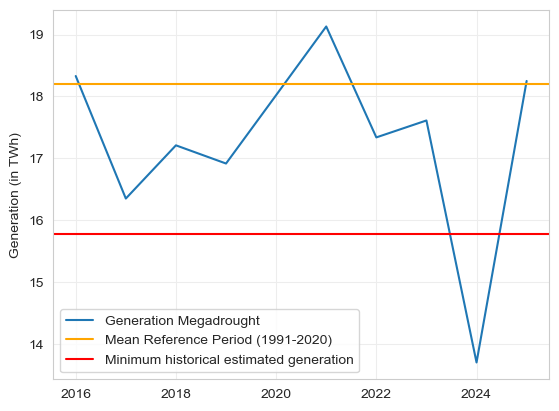

In [22]:
fig, ax = plt.subplots()
df_hydropower_yearly_megadrought["Estimated Generation No Beta"].plot(ax=ax, label="Generation Megadrought")
ax.axhline(mean_ref_period_historical, color="orange", label="Mean Reference Period (1991-2020)")
ax.axhline(df_hydropower_yearly_historical["Estimated Generation No Beta"].min(), color="red", label="Minimum historical estimated generation")
ax.set_ylabel("Generation (in TWh)")
plt.legend()
plt.show()

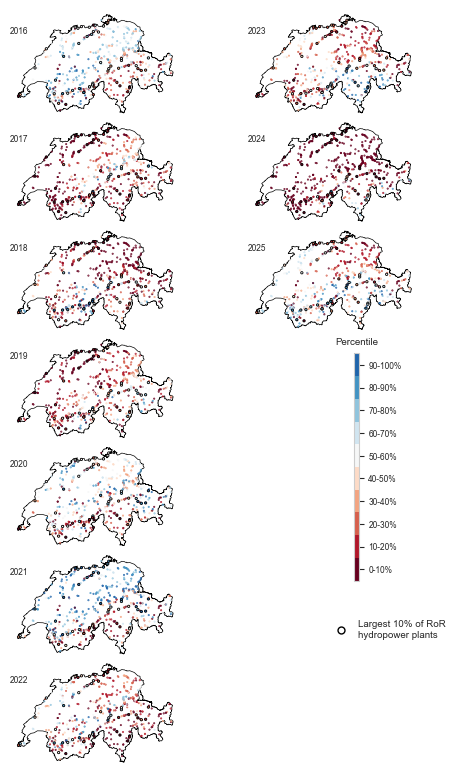

In [41]:
national_analysis_megadrought.plot_quantile_maps(yearly=True, 
                                                 variable_name="hp_no_beta",
                                                 nb_plots_col=7,
                                                 with_decade_visualization=False,
                                                 save=False,
                                                 with_operation_start=False)

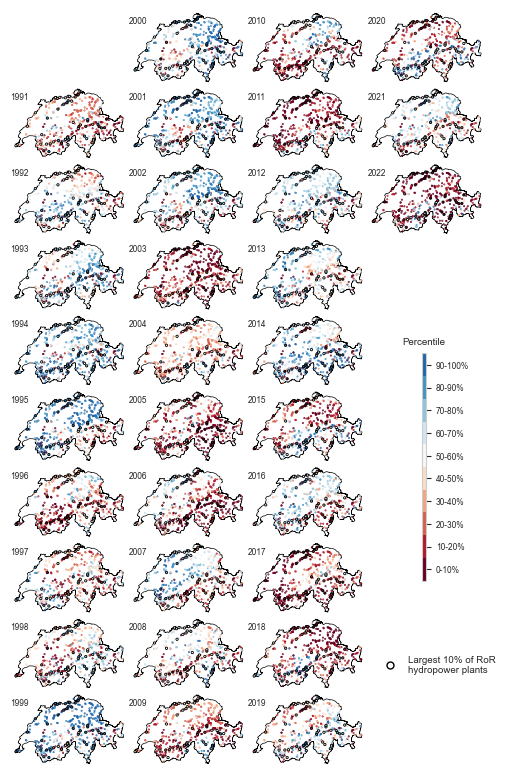

In [39]:
national_analysis_historical.plot_quantile_maps(yearly=True, 
                                                 variable_name="hp_no_beta",
                                                 nb_plots_col=10,
                                                 with_decade_visualization=True,
                                                 save=False,
                                                 with_operation_start=False)